## Setups

In [1]:
from Custom.WindowGenerator import WindowGenerator
# import matplotlib as mpl
from functools import partial
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
K = keras.backend
# import os
# os.environ["MKL_THREADING_LAYER"] = "GNU"
# os.environ["CUDA_VISIBLE_DEVICES"] = '2'

# mpl.rcParams['figure.dpi'] = 110

model_dic = {}

if not tf.test.is_built_with_cuda():
    raise print("No GPU found")

with open("subject_details.json", "r") as f:
    subject_details = json.load(f)

### Scaling functions

In [2]:
def scale_moment(data, weight, scale=True):
    if scale:
        data.iloc[:, -4:] = data.iloc[:, -4:]/weight
    return data


def scale_angle(data, angle_scaler, scale=True):
    if scale:
        columns = data.columns[-8:-4]
        data[columns] = angle_scaler.transform(data[columns])
    return data


def scale_features(data, scaler):
    data.iloc[:, :-8] = scaler.transform(data.iloc[:, :-8])
    return data

### Dataset/Training

In [3]:
def make_dataset(window_object):
    train_set = window_object.get_train_dataset()
    val_set = window_object.get_val_dataset()
    test_set = window_object.get_evaluation_set()
    return train_set, val_set, test_set


def custom_loss(y_true, y_pred):
    error = tf.reshape(y_true - y_pred, (-1, 1))
    error = error[~tf.math.is_nan(error)]
    return tf.reduce_mean(tf.square(error), axis=0)

# Custom evaluation functions


def nan_R2(y_true, y_pred):
    R2 = []
    _, l = np.shape(y_true)
    for i in range(l):
        y_true_col = y_true[:, i]
        y_pred_col = y_pred[:, i]
        logic = np.isfinite(y_true_col)
        y_true_col = y_true_col[logic]
        y_pred_col = y_pred_col[logic]
        R2.append(metrics.r2_score(y_true_col, y_pred_col))
    return np.around(R2, 4)


def nan_rmse(y_true, y_pred):
    MSE = partial(metrics.mean_squared_error, squared=False)
    rmse = []
    _, l = np.shape(y_true)
    for i in range(l):
        y_true_col = y_true[:, i]
        y_pred_col = y_pred[:, i]
        logic = np.isfinite(y_true_col)
        y_true_col = y_true_col[logic]
        y_pred_col = y_pred_col[logic]
        rmse.append(MSE(y_true_col, y_pred_col))
    return np.around(rmse, 2)

### Plotting

In [4]:
def plot_learning_curve(history):
    if history == None:
        print("No train history was found")
        return None
    else:
        plt.figure("Learning curve")
        plt.plot(history.epoch, history.history['loss'],
                 history.epoch, history.history['val_loss'])
        plt.legend(["train loss", "val loss"])
        plt.xlabel("Epochs")
        plt.ylabel("loss")
        plt.show()
        plt.savefig(f"{folder}learning_curve.pdf")
        # plt.close()
        return None


def plot_results(window_object, y_true, y_pred, R2_score, rmse_result):
    global time
    time = [i/20 for i in range(len(y_true))]
    plt.figure("Prediction")
    labels = window_object.out_labels
    for i, col in enumerate(list(labels)):
        plt.subplot(len(labels), 1, i+1)
        print(f"{col} R2 score: {R2_score[i]}")
        print(f"{col} RMSE result: {rmse_result[i]}")
        plt.plot(time, y_true[:, i], linewidth=2.5)
        plt.plot(time, y_pred[:, i], "r--", linewidth=2.5,)
        plt.title(col)
        plt.legend(["y_true", "y_pred"])
        plt.xlim((time[-600], time[-100]))
        plt.xlabel("Time [s]")
        if "moment" in col:
            plt.ylabel("Moment [Nm]")
        else:
            plt.ylabel("Angle [Degree]")
    plt.savefig(f"{folder}{labels[i]}.pdf")
    plt.show()
    # plt.close()

### Window object creation function

In [5]:
def create_window_generator(subject=None):
    if subject==None:
        subject = input("Please input subject number in XX format: ")
    if len(subject)==1:
        subject = "0" + subject
    
    w = subject_details[f'S{subject}']['weight']
    dataset_folder = f"../Dataset/S{subject}/"
    trials = ["train_01", "train_02", "val", "test"]
    trials = list(map(lambda x: f"{dataset_folder}{x}_dataset.csv", trials))
    train_01_df = scale_moment(pd.read_csv(trials[0], index_col='time'), weight=w)
    train_02_df = scale_moment(pd.read_csv(trials[1], index_col='time'), weight=w)
    val_df = scale_moment(pd.read_csv(trials[2], index_col='time'), weight=w)
    test_df = scale_moment(pd.read_csv(trials[3], index_col='time'), weight=w)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_01_df.iloc[:400, :-8])
    angle_scaler = MinMaxScaler(feature_range=(0, 1))
    angle_scaler.fit(train_01_df.iloc[:400, -8:-4])
    for data in [train_01_df, train_02_df, val_df, test_df]:
        data = scale_features(data, scaler)
        data = scale_angle(data, angle_scaler)

    # Create Window object
    window_object = WindowGenerator(train_01_df=train_01_df, train_02_df=train_02_df,
                        val_df=val_df, test_df=test_df, batch_size=64,
                        input_width=5, shift=1, label_width=1)
    return window_object

#### Train/Eval function

In [6]:
def train_fit(subject, model_name, epochs=1, lr=0.001, eval_only=False, load_best=False):
    
    window_object = create_window_generator(subject)
    # setup model folder
    global folder
    folder = f"../Results/indiviuals/{model_name}/S{subject}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
  
    w = subject_details[f'S{subject}']['weight']
    # Get all dataset
    train_set, val_set, test_set = make_dataset(window_object)
    ##############################################################################################################
    # Load and compile new model
    K.clear_session()
    model = model_dic[model_name](window_object)
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=lr),
                  loss="mean_squared_error")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{folder}S{subject}_{model_name}.hdf5",
        save_weights_only=True, monitor='val_loss',
        save_best_only=True)

    if load_best:
        try:
            model.load_weights(f"{folder}/S{subject}_{model_name}.hdf5")
        except:
            print("No saved model existing. weights will be initialized")
    ##############################################################################################################
    # Train Model
    try:  # Train or load the best model the model
        if not eval_only:
            history = model.fit(x=train_set, validation_data=val_set,
                                epochs=epochs, callbacks=[model_checkpoint_callback])
            plot_learning_curve(history)
            # Load the best model
            model.load_weights(f"{folder}/S{subject}_{model_name}.hdf5")
        else:
            history = "No training was conducted"
            model.load_weights(f"{folder}/S{subject}_{model_name}.hdf5")
    except KeyboardInterrupt:
        history = "\n\nTrains stopped manually"
        print(history)
    except OSError:  # If no saved model to be evaluated exist
        print("No saved model existing. weights will be initialized")
    ##############################################################################################################
    # Get predictions and real values
    y_pred = model.predict(test_set)
    if len(y_pred.shape) == 3:
        y_pred = y_pred[:, -1, :]
    # Get real outputs
    for _, y_true in test_set.as_numpy_iterator():
        break
    y_true = y_true[:, -1, :]
    ##############################################################################################################
    ## Evaluation and plot
    r2_score = nan_R2(w*y_true, w*y_pred)
    rmse_result = nan_rmse(w*y_true, w*y_pred)
    plot_results(window_object, y_true, y_pred, r2_score, rmse_result)
    plt.show()
    return history, y_true, y_pred, r2_score, rmse_result

### Models

In [7]:
def create_lstm_model(window_object):
    # kernel_regularizer='l2', recurrent_regularizer='l2', activity_regularizer='l2')
    custom_LSTM = partial(layers.LSTM, dropout=0.3,
                            kernel_regularizer='l2', recurrent_regularizer='l2', activity_regularizer='l2')
    lstm_model = keras.models.Sequential([
        layers.InputLayer((window_object.input_width,
                          window_object.features_num)),
        # layers.BatchNormalization(),
        custom_LSTM(128, return_sequences=True),
        custom_LSTM(128, return_sequences=True),
        custom_LSTM(128, return_sequences=False),
        layers.Dense(window_object.out_nums * window_object.label_width),
        # window_object.out_nums
        layers.Reshape([window_object.label_width, window_object.out_nums])
    ])
    return lstm_model

def create_conv_model(window_object):
    conv_model = keras.models.Sequential([
        layers.InputLayer((window_object.input_width,
                          window_object.features_num)),
        # layers.BatchNormalization(),
        layers.Conv1D(filters=10, kernel_size=3, strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(filters=20, kernel_size=3, strides=1, padding='same'),
        layers.Conv1D(filters=window_object.out_nums, kernel_size=1, strides=1)
    ])
    return conv_model


model_dic["lstm_model"] = create_lstm_model
model_dic["conv_model"] = create_conv_model

## Main

In [8]:
w1 = create_window_generator(subject="1")
w2 = create_window_generator(subject="2")
w4 = create_window_generator(subject="4")

Epoch 1/500
57/57 [==============================] - 11s 48ms/step - loss: 4.2254 - val_loss: 1.4080
Epoch 2/500
57/57 [==============================] - 2s 29ms/step - loss: 0.6637 - val_loss: 0.2401
Epoch 3/500
57/57 [==============================] - 1s 24ms/step - loss: 0.1638 - val_loss: 0.0980
Epoch 4/500
57/57 [==============================] - 1s 24ms/step - loss: 0.1033 - val_loss: 0.0782
Epoch 5/500
57/57 [==============================] - 1s 26ms/step - loss: 0.0954 - val_loss: 0.0740
Epoch 6/500
57/57 [==============================] - 1s 25ms/step - loss: 0.0917 - val_loss: 0.0744
Epoch 7/500
57/57 [==============================] - 1s 24ms/step - loss: 0.0892 - val_loss: 0.0694
Epoch 8/500
57/57 [==============================] - 2s 29ms/step - loss: 0.0893 - val_loss: 0.0675
Epoch 9/500
57/57 [==============================] - 1s 25ms/step - loss: 0.0868 - val_loss: 0.0647
Epoch 10/500
57/57 [==============================] - 1s 24ms/step - loss: 0.0862 - val_loss: 0.072

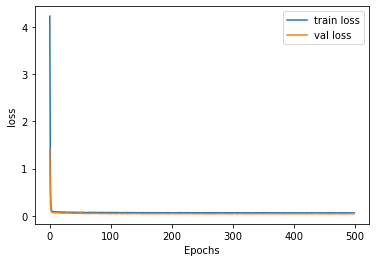

ankle moment R2 score: 0.8303
ankle moment RMSE result: 14.23


<Figure size 432x288 with 0 Axes>

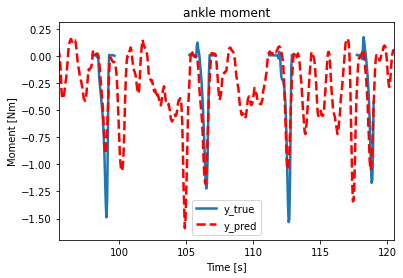

Epoch 1/500
57/57 [==============================] - 11s 68ms/step - loss: 0.3575 - val_loss: 0.1001
Epoch 2/500
57/57 [==============================] - 2s 35ms/step - loss: 0.0846 - val_loss: 0.0756
Epoch 3/500
57/57 [==============================] - 2s 35ms/step - loss: 0.0709 - val_loss: 0.0621
Epoch 4/500
57/57 [==============================] - 2s 35ms/step - loss: 0.0640 - val_loss: 0.0560
Epoch 5/500
57/57 [==============================] - 2s 36ms/step - loss: 0.0608 - val_loss: 0.0504
Epoch 6/500
57/57 [==============================] - 2s 35ms/step - loss: 0.0573 - val_loss: 0.0499
Epoch 7/500
57/57 [==============================] - 2s 38ms/step - loss: 0.0563 - val_loss: 0.0457
Epoch 8/500
57/57 [==============================] - 2s 38ms/step - loss: 0.0530 - val_loss: 0.0437
Epoch 9/500
57/57 [==============================] - 2s 35ms/step - loss: 0.0524 - val_loss: 0.0454
Epoch 10/500
57/57 [==============================] - 2s 34ms/step - loss: 0.0505 - val_loss: 0.042

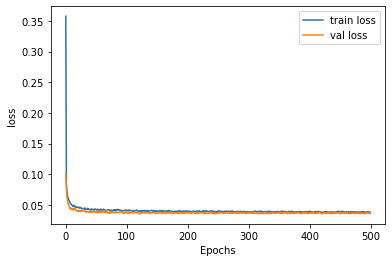

ankle moment R2 score: 0.737
ankle moment RMSE result: 17.71


<Figure size 432x288 with 0 Axes>

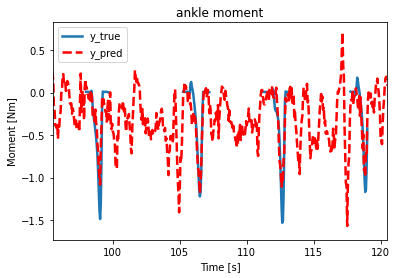

Epoch 1/500
70/70 [==============================] - 28s 139ms/step - loss: 3.6757 - val_loss: 0.9116
Epoch 2/500
70/70 [==============================] - 5s 77ms/step - loss: 0.4075 - val_loss: 0.1420
Epoch 3/500
70/70 [==============================] - 5s 75ms/step - loss: 0.1274 - val_loss: 0.0897
Epoch 4/500
70/70 [==============================] - 5s 74ms/step - loss: 0.1061 - val_loss: 0.0846
Epoch 5/500
70/70 [==============================] - 6s 80ms/step - loss: 0.1012 - val_loss: 0.0749
Epoch 6/500
70/70 [==============================] - 5s 76ms/step - loss: 0.0989 - val_loss: 0.0737
Epoch 7/500
70/70 [==============================] - 5s 75ms/step - loss: 0.0951 - val_loss: 0.0707
Epoch 8/500
70/70 [==============================] - 5s 77ms/step - loss: 0.0966 - val_loss: 0.0711
Epoch 9/500
70/70 [==============================] - 5s 77ms/step - loss: 0.0942 - val_loss: 0.0643
Epoch 10/500
70/70 [==============================] - 5s 76ms/step - loss: 0.0922 - val_loss: 0.06

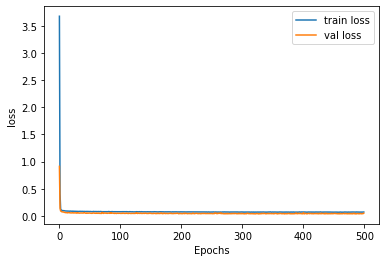

ankle moment R2 score: 0.8457
ankle moment RMSE result: 10.01


<Figure size 432x288 with 0 Axes>

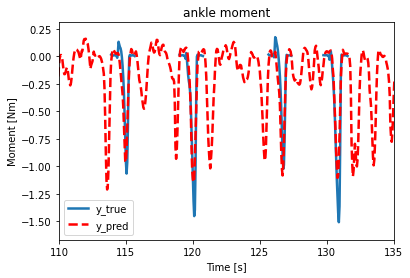

Epoch 1/500
70/70 [==============================] - 11s 57ms/step - loss: 0.1539 - val_loss: 0.0996
Epoch 2/500
70/70 [==============================] - 3s 46ms/step - loss: 0.0742 - val_loss: 0.0785
Epoch 3/500
70/70 [==============================] - 3s 42ms/step - loss: 0.0700 - val_loss: 0.0620
Epoch 4/500
70/70 [==============================] - 3s 41ms/step - loss: 0.0678 - val_loss: 0.0572
Epoch 5/500
70/70 [==============================] - 3s 47ms/step - loss: 0.0662 - val_loss: 0.0518
Epoch 6/500
70/70 [==============================] - 2s 36ms/step - loss: 0.0654 - val_loss: 0.0502
Epoch 7/500
70/70 [==============================] - 3s 47ms/step - loss: 0.0639 - val_loss: 0.0490
Epoch 8/500
70/70 [==============================] - 3s 45ms/step - loss: 0.0609 - val_loss: 0.0500
Epoch 9/500
70/70 [==============================] - 3s 36ms/step - loss: 0.0600 - val_loss: 0.0458
Epoch 10/500
70/70 [==============================] - 4s 53ms/step - loss: 0.0594 - val_loss: 0.049

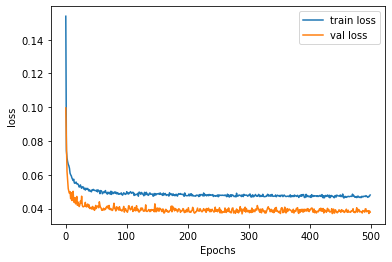

ankle moment R2 score: 0.7924
ankle moment RMSE result: 11.61


<Figure size 432x288 with 0 Axes>

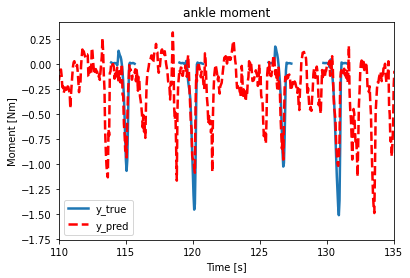

Epoch 1/500
64/64 [==============================] - 32s 170ms/step - loss: 3.8757 - val_loss: 1.0877
Epoch 2/500
64/64 [==============================] - 5s 85ms/step - loss: 0.4634 - val_loss: 0.1475
Epoch 3/500
64/64 [==============================] - 6s 89ms/step - loss: 0.0964 - val_loss: 0.0651
Epoch 4/500
64/64 [==============================] - 6s 91ms/step - loss: 0.0612 - val_loss: 0.0583
Epoch 5/500
64/64 [==============================] - 6s 97ms/step - loss: 0.0566 - val_loss: 0.0490
Epoch 6/500
64/64 [==============================] - 6s 97ms/step - loss: 0.0543 - val_loss: 0.0499
Epoch 7/500
64/64 [==============================] - 6s 95ms/step - loss: 0.0534 - val_loss: 0.0519
Epoch 8/500
64/64 [==============================] - 6s 91ms/step - loss: 0.0524 - val_loss: 0.0423
Epoch 9/500
64/64 [==============================] - 6s 94ms/step - loss: 0.0506 - val_loss: 0.0422
Epoch 10/500
64/64 [==============================] - 6s 94ms/step - loss: 0.0509 - val_loss: 0.04

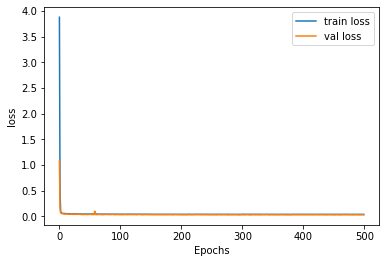

ankle moment R2 score: 0.8412
ankle moment RMSE result: 10.13


<Figure size 432x288 with 0 Axes>

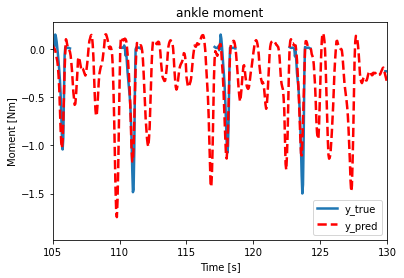

Epoch 1/500
64/64 [==============================] - 9s 48ms/step - loss: 0.1853 - val_loss: 0.0835
Epoch 2/500
64/64 [==============================] - 2s 32ms/step - loss: 0.0461 - val_loss: 0.0543
Epoch 3/500
64/64 [==============================] - 2s 30ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 4/500
64/64 [==============================] - 2s 31ms/step - loss: 0.0335 - val_loss: 0.0363
Epoch 5/500
64/64 [==============================] - 2s 28ms/step - loss: 0.0324 - val_loss: 0.0321
Epoch 6/500
64/64 [==============================] - 2s 30ms/step - loss: 0.0311 - val_loss: 0.0301
Epoch 7/500
64/64 [==============================] - 2s 29ms/step - loss: 0.0296 - val_loss: 0.0304
Epoch 8/500
64/64 [==============================] - 2s 27ms/step - loss: 0.0305 - val_loss: 0.0281
Epoch 9/500
64/64 [==============================] - 2s 31ms/step - loss: 0.0295 - val_loss: 0.0276
Epoch 10/500
64/64 [==============================] - 2s 30ms/step - loss: 0.0290 - val_loss: 0.0289

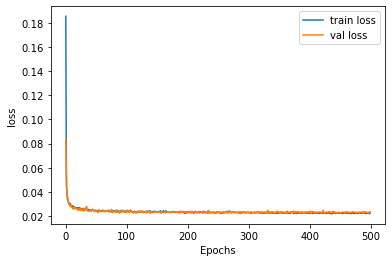

ankle moment R2 score: 0.7522
ankle moment RMSE result: 12.66


<Figure size 432x288 with 0 Axes>

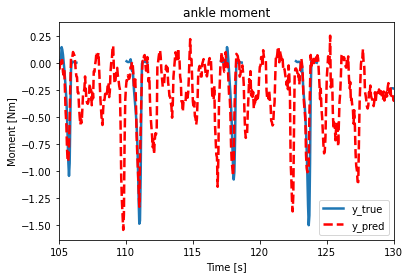

In [9]:
model_name = "lstm_model"

# Train and test new/existing models
for s in ["01","02","04"]:
    for model_name in model_dic.keys():
        history, y_true, y_pred, r2, rmse = train_fit(s, model_name, epochs=500, eval_only=False, load_best=False)